# Object Detection Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถตรวจจับวัตถุได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ นำมาหาค่ากรอบของวัตถุที่สำคัญ เพื่อใช้แสดงผลเป็นรูปทรงเรขาคณิตของใบหน้าจำนวน 4 พิกัด พร้อมกับชื่อวัตถุและค่าความเชื่อมั่น (score) <br><br>

![object_detection_example.png](https://mediapipe.dev/images/mobile/object_detection_android_gpu.gif)<br><br>

ในการวัดตำแหน่งของวัตถุจะถูกแบ่งเป็น 9 ทิศทาง ได้แก่ ตรงกลางภาพ, บนขวา, ล่างขวา, บนซ้าย, ล่างซ้าย, กลางขวา, กลางซ้าย, บนกลาง, และล่างกลาง

โดยทำการวัดจากจุดกึ่งกลางของวัตถุ เปรียบเทียบกับจุดกึ่งกลางของภาพ หากระยะห่างของจุดกึ่งกลางวัตถุ *ไม่เกิน 5 เปอร์เซ็น* จากจุดกึ่งกลางภาพ วัตถุนั้นจะถูกนับว่าอยู่ตรงกลางของภาพ

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อใช้งานตัวโมเดลจาก Mediapipe ในการทำนายทิศทางของวัตถุบนรูป และแสดงผลเป็นรูปภาพที่วาดกรอบสี่เหลี่ยมรอบวัตถุและใส่ชื่อวัตถุพร้อมค่าความเชื่อมั่น โดยประกอบด้วย 6 ขั้นตอนดังต่อไปนี้

**ขั้นตอนที่ 1** เชื่อมต่อ Google Drive เพื่อค้นหารูปภาพตัวอย่างที่เก็บอยู่ใน Drive ของคุณ

In [ ]:
# Connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**ขั้นตอนที่ 2** นำเข้าโมเดลจาก Mediapipe

In [ ]:
import requests
import os
import tensorflow as tf

# Load the TFLite model and allocate tensors.
# Ref. https://google.github.io/mediapipe/solutions/models.html#object-detection

# URL of the TFLite model
model_url = "https://storage.googleapis.com/mediapipe-tasks/object_detector/efficientdet_lite2_uint8.tflite"

response = requests.get(model_url)
open("object_model.tflite", "wb").write(response.content)

# Download the model
if not os.path.exists("object_model.tflite"):
    response = requests.get(model_url)
    open("object_model.tflite", "wb").write(response.content)

# Load the TFLite model
model = tf.lite.Interpreter(model_path="object_model.tflite")
model.allocate_tensors()

# Get input and output tensors.
input_details = model.get_input_details()
output_details = model.get_output_details()

**ขั้นตอนที่ 3** นำเข้ารายการชื่อวัตถุของโมเดล

In [ ]:
import pandas as pd

# Load the classes of model.
# Ref. https://developers.google.com/mediapipe/solutions/vision/object_detector

class_url = "https://storage.googleapis.com/mediapipe-tasks/object_detector/labelmap.txt"

# Import the classes.txt file into a Pandas dataframe
df_class = pd.read_csv(class_url, header=None, names=['name'])
df_class.head()

,name
0,person
1,bicycle
2,car
3,motorcycle
4,airplane


**ขั้นตอนที่ 4** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล

In [ ]:
import numpy as np
import cv2

# Path of the input image
image_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/cocos/11.jpg"

# !wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/object_detector/cat_and_dog.jpg
# image_path = 'image.jpg'

# Load the image to predict
img = cv2.imread(image_path) # read image from path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert an image to RGB color space
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model

**ขั้นตอนที่ 5** ประมวลผลรูปผ่านโมเดลเพื่อทำนายวัตถุ

In [ ]:
# Pass the image and Run the model on the image
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# Get keypoints from the output
boxes = model.get_tensor(output_details[0]['index']) # [ y_start, x_start, y_end, x_end ]
classes = model.get_tensor(output_details[1]['index']).astype(np.uint8) # ID range (0 - 89) = 90 items 
scores = model.get_tensor(output_details[2]['index']) # Accuracy (0 - 1)

**ขั้นตอนที่ 6** แสดงผลรูปการทำนายวัตถุพร้อมกับตำแหน่งของวัตถุนั้น

Position of cat : lower left


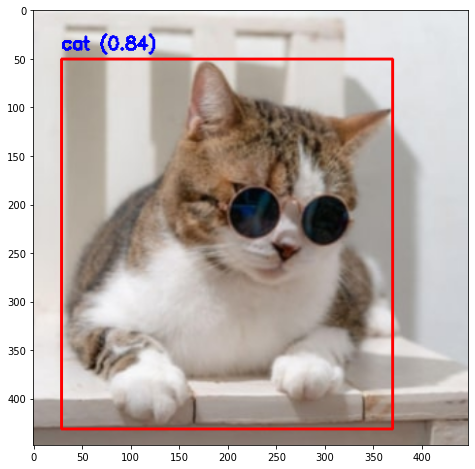

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def calculate_position(box, imgsize, alpha=0.05): # alpha: offset-percent
    # Calculate the center of the image
    center_image_x = imgsize[2] / 2
    center_image_y = imgsize[1] / 2
    
    # Calculate the center of the object's bounding box
    center_object_x = (int(box[1]) + int(box[3])) / 2
    center_object_y = (int(box[0]) + int(box[2])) / 2
    
    # Calculate cutoff direction
    cutoff_x = np.multiply(center_image_x, np.multiply(alpha,[-1,1])+1)
    cutoff_y = np.multiply(center_image_y, np.multiply(alpha,[-1,1])+1)
    
    # Determine the location of the object
    if center_object_x <= cutoff_x[0] and center_object_y <= cutoff_y[0]:
        location = "upper left"
    elif center_object_x <= cutoff_x[0] and center_object_y >= cutoff_y[1]:
        location = "lower left"
    elif center_object_x >= cutoff_x[1] and center_object_y <= cutoff_y[0]:
        location = "upper right"
    elif center_object_x >= cutoff_x[1] and center_object_y >= cutoff_y[1]:
        location = "lower right"
    elif center_object_x <= cutoff_x[0] and center_object_y >= cutoff_y[0] and center_object_y <= cutoff_y[1]:
        location = "center left"
    elif center_object_x >= cutoff_x[1] and center_object_y >= cutoff_y[0] and center_object_y <= cutoff_y[1]:
        location = "center right"
    elif center_object_x >= cutoff_x[0] and center_object_x <= cutoff_x[1] and center_object_y <= cutoff_y[0]:
        location = "upper center"
    elif center_object_x >= cutoff_x[0] and center_object_x <= cutoff_x[1] and center_object_y >= cutoff_y[1]:
        location = "lower center"
    else:
        location = "center"
    return location

# Show the output image
fig, ax = plt.subplots(figsize=(8, 8)) # define size of figure
plt.imshow(img) # display image in the figure

# Draw boxes and class labels on the image
for i in range(boxes.shape[1]):
    if scores[0, i] > 0.5:
        box = boxes[0, i, :] * np.array([img.shape[0], img.shape[1], img.shape[0], img.shape[1]])
        cv2.rectangle(img, (int(box[1]), int(box[0])), (int(box[3]), int(box[2])), (255, 0, 0), 2)
        text = df_class.name[int(classes[0, i])] + " (" + "{:.2f}".format(scores[0, i]) + ")"
        cv2.putText(img, text, (int(box[1]), int(box[0])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        # Object Location Prediction
        location = calculate_position(box, input_details[0]['shape'])
        
        # Print the output
        print("Position of", df_class.name[int(classes[0, i])], ":", location)


# Display the output image using matplotlib
plt.imshow(img)
plt.show()